In [65]:
library(ggplot2)
library(openxlsx)
library(VennDiagram)
library(RColorBrewer)
library(igraph)
library(kimono)
library(ggnet)
library(orthologsBioMART)
library(tidyverse)
library(dplyr)
library(forcats)

In [28]:
network = as.data.frame(read.xlsx("data/Tables/S7_GRtrio-Network.xlsx"))
dim(network)
head(network)

[1] 849  11

,target,predictor,mean_value,sd_value,mean_rsq,sd_rsq,mean_mse,sd_mse,sel_freq,predictor_layer,target_layer
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,ENSG00000069399,rs5995992,0.05471702,0.010437754,0.2226648,0.03159546,0.5509747,0.02684950,1,SNP,Gene
2,ENSG00000069399,rs2267424,-0.05328072,0.007148959,0.2226648,0.03159546,0.5509747,0.02684950,1,SNP,Gene
3,ENSG00000069399,rs5758223,0.06247073,0.010350832,0.2226648,0.03159546,0.5509747,0.02684950,1,SNP,Gene
4,ENSG00000069399,rs5751040,0.07166127,0.012167511,0.2226648,0.03159546,0.5509747,0.02684950,1,SNP,Gene
5,ENSG00000069399,rs738628,-0.05406277,0.010189122,0.2226648,0.03159546,0.5509747,0.02684950,1,SNP,Gene
6,ENSG00000100297,rs61467269,-0.04066821,0.010352007,0.2458373,0.02703095,0.5016785,0.02741214,1,SNP,Gene


## Panel A - GR-trio network 

Warning message in is.null(x) || is.na(x):
“'length(x) = 1078 > 1' in coercion to 'logical(1)'”
Warning message in is.null(x) || is.na(x) || is.infinite(x):
“'length(x) = 1078 > 1' in coercion to 'logical(1)'”
Warning message in is.null(x) || is.na(x) || is.infinite(x) || is.nan(x):
“'length(x) = 1078 > 1' in coercion to 'logical(1)'”


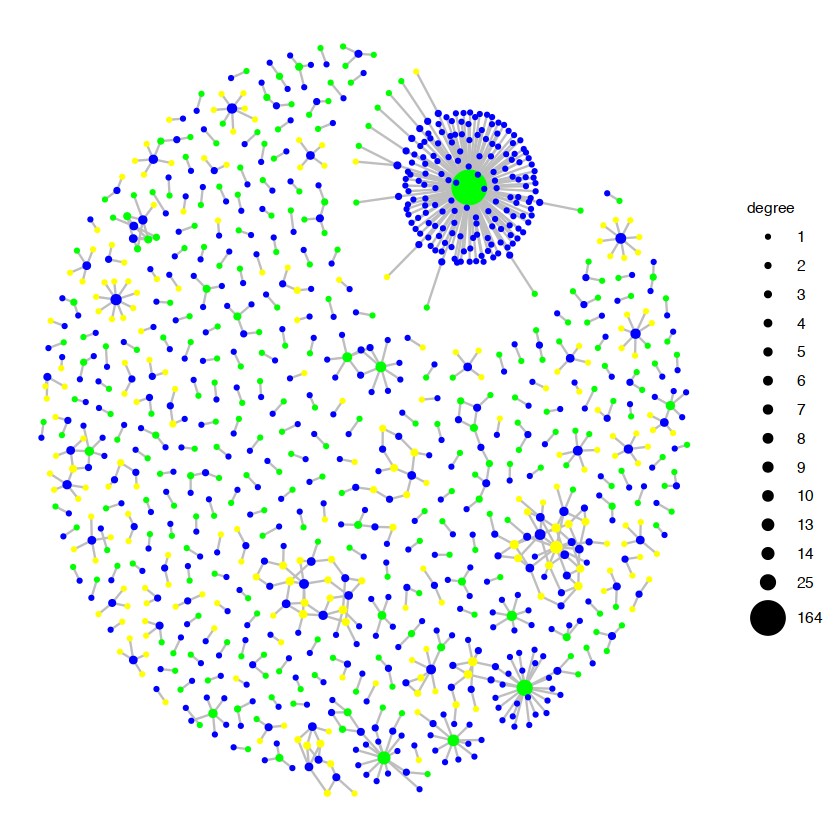

In [32]:
# create network
ig_network = to_igraph(network, directed=TRUE) 
#ig_network %>% plot_kimono
node_labels = V(ig_network)$name

# extract top layer
gene_part = as.character(sapply(node_labels, function(x) gsub("^(.*?)__.*$", "\\1", x)))

# create color vec
node_color = ifelse(gene_part == "Gene", "blue",
                                   ifelse(gene_part == "CpG", "green",
                                          ifelse(gene_part == "SNP", "yellow", "red")))

ggnet2(ig_network, node.size = 1, node.color = node_color, edge.size = 0.5,
       edge.color = "grey",size = "degree")

## Panel B - Barplot

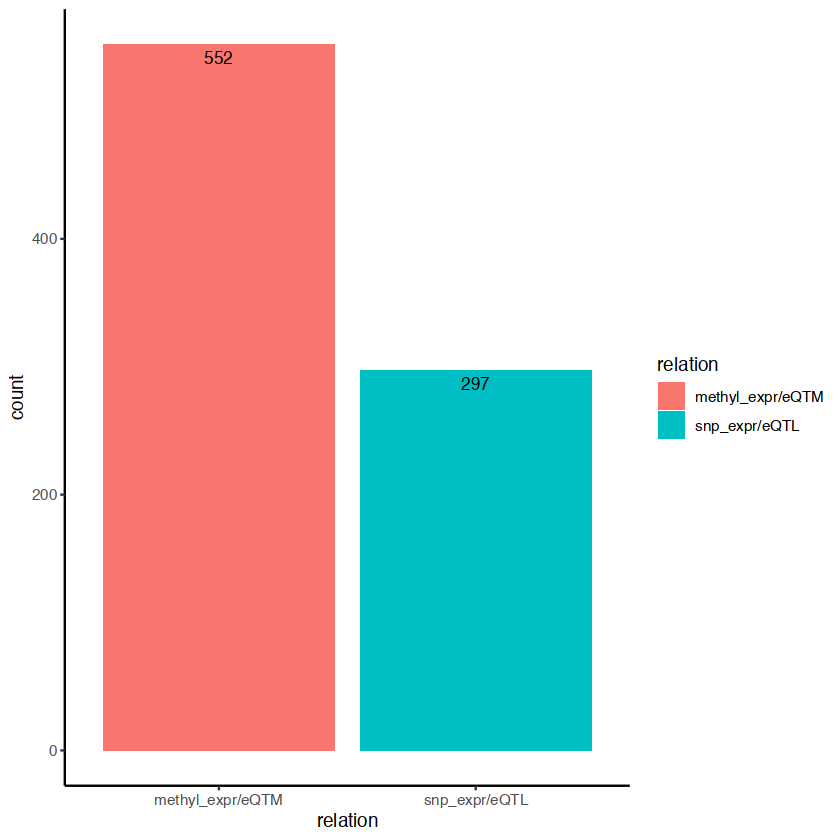

In [33]:
network.df = as.data.frame(network)
network.df$relation = ""
network.df[ network.df$predictor_layer=="CpG" & network.df$target_layer=="Gene",]$relation = "methyl_expr/eQTM"
network.df[ network.df$predictor_layer=="SNP" & network.df$target_layer=="Gene",]$relation = "snp_expr/eQTL"

ggplot(network.df, aes(relation, fill=relation)) + geom_bar(stat = "count") +
 geom_text(stat = "count",  aes(label = ..count..), vjust = 1.5,
           position = position_dodge(0.9), size = 3.5) + theme_classic()

## Panel C - GO pathways 

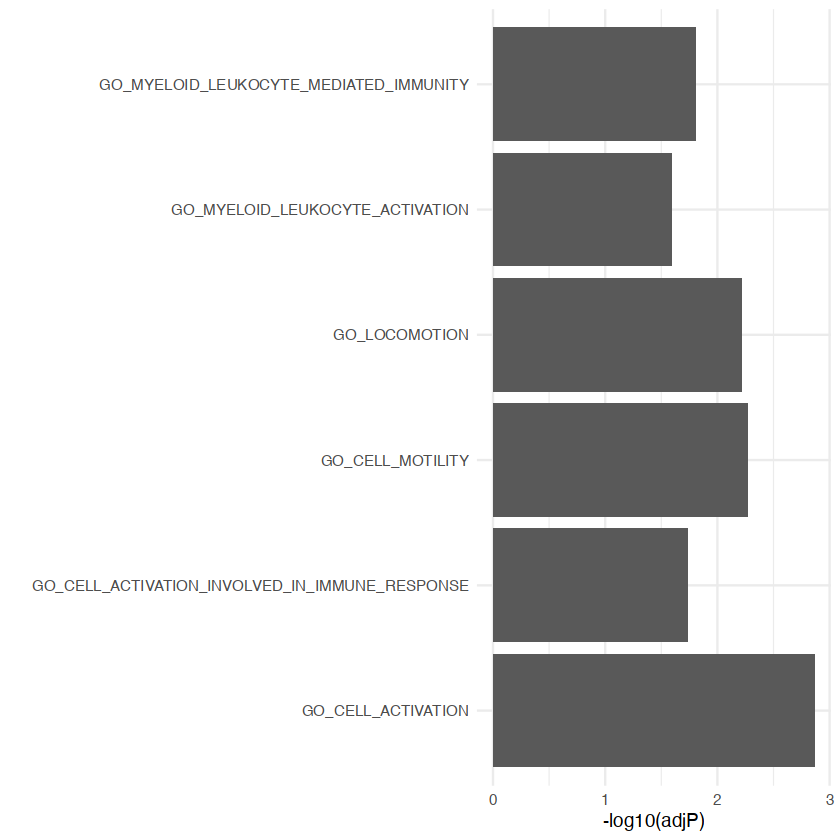

In [34]:
fuma = read.delim("data/Fuma_GS.txt")
fuma.go = fuma[ fuma$Category == "GO_bp",]

ggplot(data = fuma.go, aes(x=GeneSet, y=-log10(adjP))) +
  geom_bar(position="dodge", stat="identity") + theme_minimal() +coord_flip()+xlab("")

## Panel D-E - Venn diagram  and Bar plot (DiffBrainNet)

In [37]:
diffbrain = read.csv("data/DiffBrainNet_DEGenes.csv")
length(unique(diffbrain$Ensembl_ID))

[1] 2092

In [47]:
# lift to human genes
diffbrain_h=findOrthologsMmHs(from_filters = "ensembl_gene_id",
                  from_values = diffbrain$Ensembl_ID,
                  to_attributes = "hgnc_symbol")
dim(diffbrain_h)
length(unique(diffbrain_h$human_ensembl_gene_id))

[1] 2026    3

[1] 2015

In [43]:
trio =read.delim("data/GRtrio_genes.txt", head=F)
length(unique(trio$V1))

[1] 613

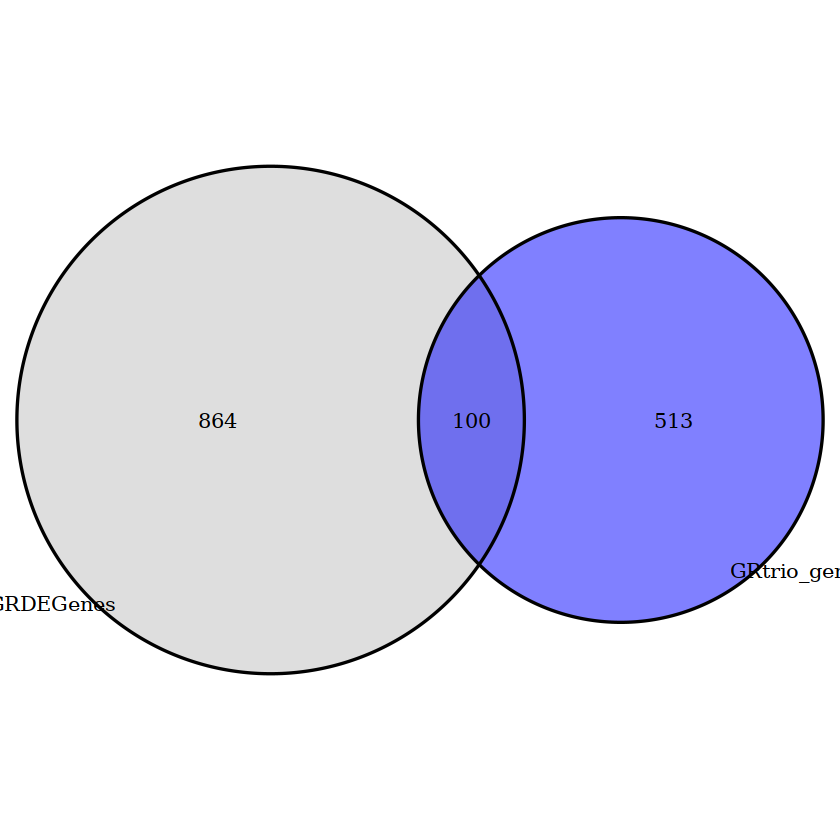

In [48]:
#shared background genes
bg=read.delim("data/GRtrio_bg.txt", head=F)

a= intersect(bg$V1 , trio$V1) 
b= intersect(bg$V1 , diffbrain_h$hgnc_symbol) 

set_colors <- c("blue", "gray")
sets <- list(GRtrio_genes = a, GRDEGenes = b)
venn_bcc=venn.diagram(sets, filename = NULL,scaled = TRUE, scaling.area = TRUE, fill = set_colors, alpha = 0.5, lwd = 2)
grid.newpage()
grid.draw(venn_bcc)

In [63]:
overlap = diffbrain[ diffbrain$Ensembl_ID %in% (diffbrain_h[ diffbrain_h$hgnc_symbol %in% 
                                                  trio$V1,]$mouse_ensembl_gene_id),]
dim(overlap)

[1] 100   4

,X,Gene_Symbol,Ensembl_ID,region
,<int>,<chr>,<chr>,<chr>
30,30,Ifrd1,ENSMUSG00000001627,"AMY, CER, dDG, dCA1, PFC, PVN, vDG, vCA1"
37,37,Nfix,ENSMUSG00000001911,"CER, dDG, dCA1, PFC, vDG, vCA1"
54,54,Nab1,ENSMUSG00000002881,PFC
70,70,Nfat5,ENSMUSG00000003847,"CER, PFC, vDG"
85,85,Arid3b,ENSMUSG00000004661,PFC
113,113,Cbfa2t3,ENSMUSG00000006362,"dDG, dCA1, PFC, vDG, vCA1"


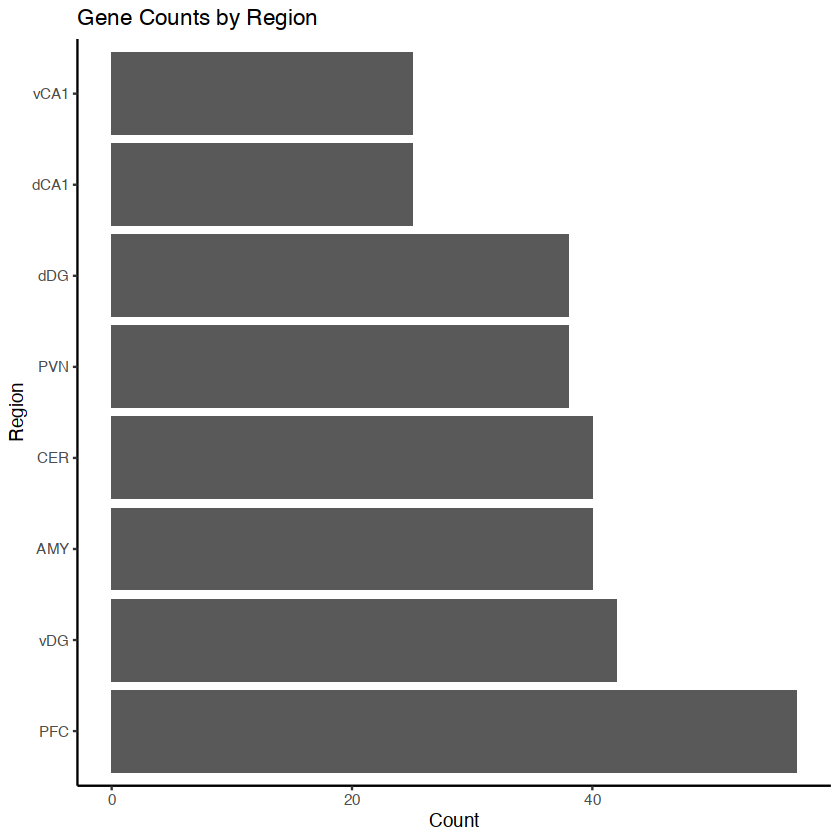

In [64]:
# Split the "region" column by commas
region_list = strsplit(overlap$region, ",")

# Flatten the list of regions
all_regions = unlist(region_list)

# Remove spaces in each entry
all_regions = gsub(" ", "", all_regions )

# Count the occurrence of each region
region_counts = table(all_regions)

# Sort the regions by count in descending order
region_counts = sort(region_counts, decreasing = TRUE)

# Create a bar plot of region counts
x = data.frame(count = region_counts)
ggplot(x,
       aes(x =  count.all_regions , y = count.Freq)) +
  geom_bar(stat = "identity" ) +
  labs(x = "Region", y = "Count") +
  ggtitle("Gene Counts by Region") +
   theme_classic() + coord_flip()

## Panel F Barplot

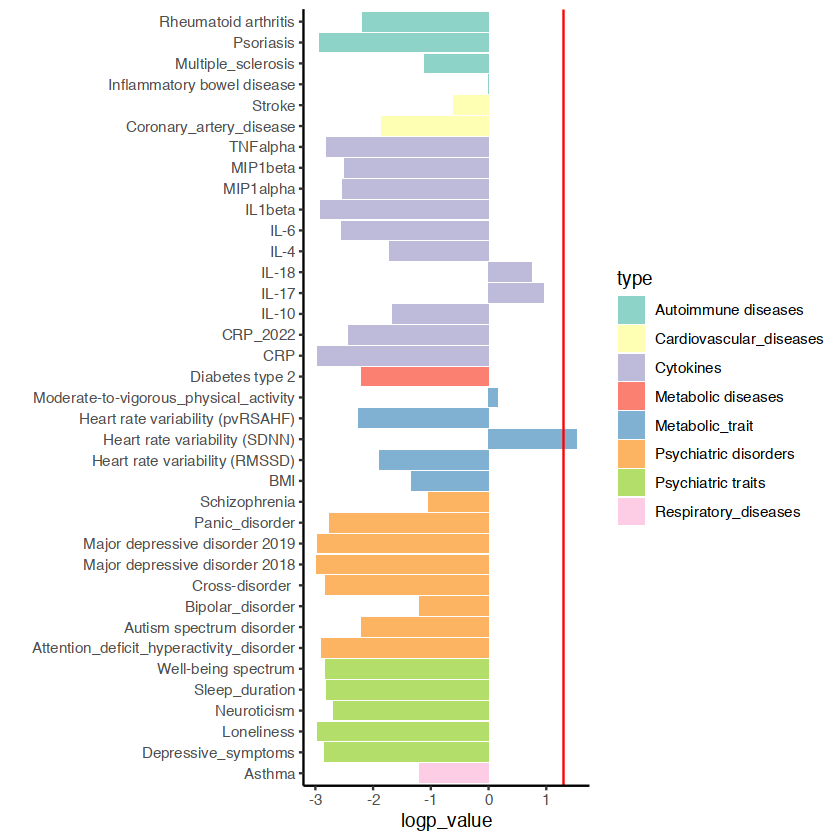

In [75]:
trios = read.csv2("data//GRtrios_snps_GWAS_enrichment_perm_1000.csv")
trios$logp_value = -log10(as.numeric(trios$p_value))

my_palette = brewer.pal(n = length(unique(trios$type)), name = "Set3")

# Sort the data frame by Type and then data within Type
trios = trios %>%
  arrange(type, data)  

ggplot(trios, aes(x = fct_reorder2(data,  data, type), y = logp_value, fill = type)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  coord_flip() +
  theme_classic() +
  geom_hline(yintercept = -log10(0.05), color = "red")+
  scale_fill_manual(values = my_palette) + xlab("")

In [76]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] orthologsBioMART_0.1.0 biomaRt_2.52.0         scales_1.2.1          
 [4] sna_2.7-1              statnet.common_4.9.0   network_1.18.1        
 [7] ggnet_0.1.0            kimono_2.0.1.0006      hmlasso_0.0.1         
[10] checkmate_2.2.0        miselect_0.9.0         impute_1.70.0         
[13] mice_3.16.0            lubridate_1.9.2        forcats_1.0.0         
[16] stringr_1.5.0          purrr_1.0.1            readr_2.1.4           
[19] tidyr_1.3.0            tibble_3.2.1           tidyverse_2.0.0       
[22] doSN